<a href="https://colab.research.google.com/github/MohamadMahdiDarvishi/Tensorflow/blob/main/Notebooks/Tensorflow_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2 : SKimLit   📰

in this notebook we are going to read through medical abstracts and find patterns on them by created NLP model

## 0. Prerequirities

In [ ]:
# Imports
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as  np
import pandas as pd
import random
import tensorflow_hub as hub
import os
from tensorflow.keras.utils import plot_model

In [ ]:
# GPU Access
!nvidia -smi -L

/bin/bash: line 1: nvidia: command not found


In [ ]:
# Importing helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import calculate_results , make_confusion_matrix , create_tensorboard_callback , unzip_data

--2023-09-19 11:51:46--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-19 11:51:46 (79.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## 1. Get Data

### 1.1 A glance at data

In [ ]:
# get data
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
# look through data
!ls 'pubmed-rct'

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 25.65 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# look through data
!ls 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign'

dev.txt  test.txt  train.txt


❗ **Note**

our data is shaped in four folders :

* `PubMed_200k_RCT` - 200k abstraction papers  
* `PubMed_20k_RCT` - 20k abstraction papers
* `PubMed_200k_RCT_numbers_replaced_with_at_sign` - 200k abstraction papers with numbers replaced with @ sign
* `PubMed_20k_RCT_numbers_replaced_with_at_sign` - 20k abstraction papers with numbers replaced with @ sign

In [ ]:
# alsp we could look through our data by os library
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

import os
data_dir_files = [data_dir + file_name for file_name in os.listdir(data_dir)]
data_dir_files

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [ ]:
# also we could look at main dataset folder
for dir_dir , dir_name , file in os.walk('pubmed-rct') :
  print(f"dir : {dir_dir} \ndir_name : {dir_name} \nfile_name : {file}")

dir : pubmed-rct 
dir_name : ['.git', 'PubMed_200k_RCT', 'PubMed_200k_RCT_numbers_replaced_with_at_sign', 'PubMed_20k_RCT', 'PubMed_20k_RCT_numbers_replaced_with_at_sign'] 
file_name : ['README.md']
dir : pubmed-rct/.git 
dir_name : ['logs', 'objects', 'branches', 'info', 'hooks', 'refs'] 
file_name : ['index', 'config', 'HEAD', 'description', 'packed-refs']
dir : pubmed-rct/.git/logs 
dir_name : ['refs'] 
file_name : ['HEAD']
dir : pubmed-rct/.git/logs/refs 
dir_name : ['heads', 'remotes'] 
file_name : []
dir : pubmed-rct/.git/logs/refs/heads 
dir_name : [] 
file_name : ['master']
dir : pubmed-rct/.git/logs/refs/remotes 
dir_name : ['origin'] 
file_name : []
dir : pubmed-rct/.git/logs/refs/remotes/origin 
dir_name : [] 
file_name : ['HEAD']
dir : pubmed-rct/.git/objects 
dir_name : ['pack', 'info'] 
file_name : []
dir : pubmed-rct/.git/objects/pack 
dir_name : [] 
file_name : ['pack-038a48bf4e31da47ea3224889132f7d41502470e.idx', 'pack-038a48bf4e31da47ea3224889132f7d41502470e.pack']
di

### 1.2 Preprocess data

> Visualize , Visualize , Visualize

we are going to write following functions(or variables) for correspondence gools :

* `get_lines` - get all dataset files
* `manage_lines` - manage the data set files extracted by `get_lines` function
* `train_df` , `val_df` ,`test_df` - the DataFrame for train , validation , test data
* `train_sentences` , `val_sentences` , `test_sentences` - the sentences in train , validation , test dataset

In [ ]:
# extracting dataset files
def get_lines(file_name) :
  """
  Extracting PubMed data set lines of abstraction papers

  Args :
    file_name (str) :  the path of train or validation dataset text file
  Returns :
    all of abstraction paper text lines

  """
  with open(file_name , "r") as f :
    return f.readlines()

In [ ]:
data_lines = get_lines(data_dir + "train.txt")
data_lines

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
# managing extracted files from dataset
def manage_lines(file_name : list) :
  """
  This function is written to manage the extracted abstract papers into a list of abstraction lines numbered lines and a target for each line
  the managment would be displayed by pandas.DataFrame

  Args (str) :
    file_name : the file of abstraction papers

  Returns :
    the function returns a list of lines with their taget and number of line in abstraction paper id and total number of lines in abstraction
    paper choosed

  """
  data_lines = get_lines(file_name)
  abstract_samples = []
  for line in data_lines :
    if line.startswith("###") :
      abstract_id = line
      abstract_lines = ""
    elif line.isspace() :
      abstract_lines_split = abstract_lines.splitlines()
      for line_number , line_text in enumerate(abstract_lines_split) :
        target = line_text.split('\t')[0]
        text = line_text.split('\t')[1].lower()
        lines_data = {}
        lines_data["line number"] = line_number
        lines_data["target"] = target
        lines_data["text"] = text
        lines_data["total lines"] = len(abstract_lines_split)
        abstract_samples.append(lines_data)
    else :
      abstract_lines += line

  return abstract_samples

In [ ]:
# make train , val and test samples
train_samples = manage_lines(data_dir + "train.txt")
val_samples = manage_lines(data_dir + "dev.txt") # dev is another name for val
test_samples = manage_lines(data_dir + "test.txt")
len(train_samples) , len(val_samples) , len(test_samples)

(180040, 30212, 30135)

In [ ]:
# making train , val , test dataf frames
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
len(train_df) , len(val_df) , len(test_df)

(180040, 30212, 30135)

In [ ]:
train_df.head()

,line number,target,text,total lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,12
1,1,METHODS,a total of @ patients with primary knee oa wer...,12
2,2,METHODS,outcome measures included pain reduction and i...,12
3,3,METHODS,pain was assessed using the visual analog pain...,12
4,4,METHODS,secondary outcome measures included the wester...,12


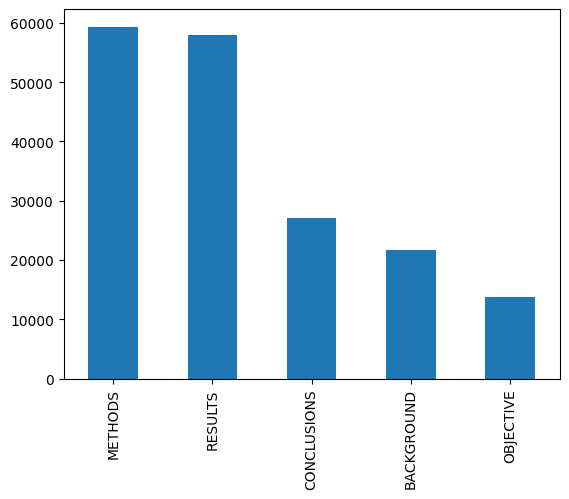

In [ ]:
train_df.target.value_counts().plot(kind = "bar") ;

In [ ]:
# train , val , test sentences
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()
len(train_sentences) ,len(val_sentences) , len(test_sentences)

(180040, 30212, 30135)

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
# encoding lables into numbers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_lables_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_lables_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_lables_encoded = label_encoder.transform(test_df["target"].to_numpy())
len(train_lables_encoded) , len(val_lables_encoded) , len(test_lables_encoded)

(180040, 30212, 30135)

In [ ]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes , class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

**one-hot encoding**

❗ **Note**

later for creating different kind of data sets we need `one-hot` encoding

In [ ]:
# importing
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output = False)

train_one_hot_label = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_one_hot_label = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_one_hot_label = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

❗ **Note**

the reason for using `fit_transform` in first position not in other positions is that in first position `OneHotEncoder` is not fitted

## 2. Build Model

Starting a series of model expriences for finding the model with bes t performance

### 2.0 **Model 0 :** baseline model

In [ ]:
# Importing baseline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# creating baseline
model_0 = Pipeline([
    ("Tfid" , TfidfVectorizer()) ,
    ("clf" , MultinomialNB())
])
# train model
model_0.fit(X = train_sentences ,
            y = train_lables_encoded)

Pipeline(steps=[('Tfid', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_0_score = model_0.score(X = val_sentences ,
                              y = val_lables_encoded)
print(f"the baseline model reach {model_0_score*100:.2f} % accuracy on validation data")

the baseline model reach 72.18 % accuracy on validation data


In [ ]:
# make prediction
model_0_pred = model_0.predict(val_sentences)
len(model_0_pred)

30212

In [ ]:
model_0_results = calculate_results(y_pred = model_0_pred ,
                                    y_true = val_lables_encoded)

**just few data analysation of our data**

* `np.percentile` - how much is the least lenght a specified percentage of our list (in this example sentences)
* `plt.hist` - make bar plot based on quantity of sentences
* `max` - builtin function for finding maximum value of list

❗ **Note**

actully one of porposes for doing this is for setting up our TextVectorizer

In [ ]:
# avearge length of sentences
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

26

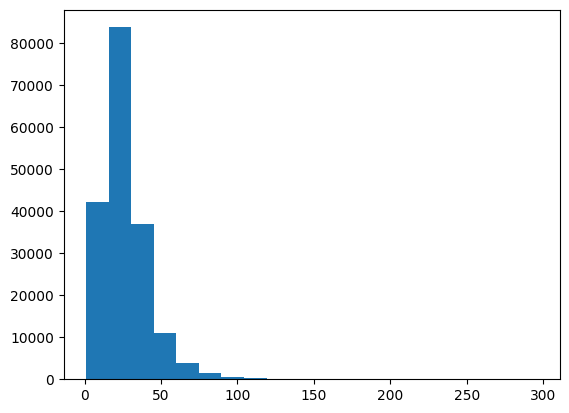

In [ ]:
# make visualization based on count of sentence lenghts
plt.hist([len(i.split()) for i in train_sentences] , bins = 20) ;

In [ ]:
# finding 95% of sentences least how long ?
overal_cover_length = np.percentile([len(i.split()) for i in train_sentences] , 95)
overal_cover_length

55.0

In [ ]:
# finding maximum number of sentences
max([len(i.split()) for i in train_sentences])

296

**Text Vectorizer layer**

In [ ]:
# GLOBAL VARIABLES
MAX_TOKENS = 68000 # How many words are gonna to be in vocabulary
OUT_SEQ_LEN = overal_cover_length # lenght of sentences returned into numbers

In [ ]:
# importing text vectorizer
from tensorflow.keras.layers.experimental.preprocessing  import TextVectorization
# setting text vectorizer up
text_vectorizer = TextVectorization(max_tokens = MAX_TOKENS ,
                                    output_sequence_length = int(OUT_SEQ_LEN))

In [ ]:
# adapting text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# getting the vocabulary of our sentences
rct_20k_vocab = text_vectorizer.get_vocabulary()
print(f"the number of words in vocabulary : {len(rct_20k_vocab)}")
print(f"the 5 most used words : {rct_20k_vocab[:5]}")
print(f"the 5 least used words : {rct_20k_vocab[-5:]}")

the number of words in vocabulary : 64841
the 5 most used words : ['', '[UNK]', 'the', 'and', 'of']
the 5 least used words : ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# making vectorization on a sample sentence
sample_sentence = random.sample(train_sentences , k=1)
print(f"sentence before vectorization(tokenization) :\n {sample_sentence[0]}\n")
vectorized_sentence = text_vectorizer(sample_sentence)
print(f"text after vectorization : \n {vectorized_sentence[0]}\n")
print(f"the length of sample sentence : {len(sample_sentence[0].split())}")

sentence before vectorization(tokenization) :
 proportions of different dose of vaccine by age by vaccine were also identified .

text after vectorization : 
 [2008    4  197  131    4  497   22  103   22  497    9  138  526    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]

the length of sample sentence : 14


In [ ]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

**Embedding Layer**

In [ ]:
from tensorflow.keras.layers import Embedding

embedding = Embedding(input_dim = len(rct_20k_vocab) ,
                      mask_zero = True ,
                      output_dim = 128 ,
                      name = "toke_embedding")

In [ ]:
# passing sample sentence through embedding layer
print(f"Text :\n {sample_sentence[0]} \n")
print(f"Vectorized :\n {vectorized_sentence[0]} \n shape : {vectorized_sentence.shape} \n")
print(f"Embedded :\n {embedding(vectorized_sentence)} \n shape : {embedding(vectorized_sentence).shape} \n")

Text :
 proportions of different dose of vaccine by age by vaccine were also identified . 

Vectorized :
 [2008    4  197  131    4  497   22  103   22  497    9  138  526    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0] 
 shape : (1, 55) 

Embedded :
 [[[ 0.00182964 -0.02270157  0.00571559 ...  0.03733642 -0.02268342
    0.00071426]
  [ 0.04372141 -0.01122649 -0.01333561 ... -0.0159683   0.04917288
    0.02120281]
  [-0.02099413 -0.01782509 -0.04720408 ... -0.02748069 -0.03587133
    0.01434844]
  ...
  [-0.04354885  0.04331751 -0.00472847 ... -0.02954531  0.04044725
   -0.01583498]
  [-0.04354885  0.04331751 -0.00472847 ... -0.02954531  0.04044725
   -0.01583498]
  [-0.04354885  0.04331751 -0.00472847 ... -0.02954531  0.04044725
   -0.01583498]]] 
 shape : (1, 55, 128) 



**Creating Datasets making our process as fast as could**

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences , train_one_hot_label))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences , val_one_hot_label))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences , test_one_hot_label))

In [ ]:
# prefetching datasets and batching our data
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### 2.1   **Model 1 :** Conv1D (word embedding)

with embedding and vectorization

In [ ]:
# Create model
inputs = tf.keras.Input(shape = (1,) , dtype = tf.string)
x = embedding(text_vectorizer(inputs))
x = tf.keras.layers.Conv1D(64 , kernel_size = 5 , padding = "same" , activation = "relu")(x)
x = tf.keras.layers.GlobalAveragePooling1D(name = "global_average_pooling_1d")(x)
outputs = tf.keras.layers.Dense(num_classes , activation = "softmax")(x)
model_1 = tf.keras.Model(inputs , outputs)

# compile model
model_1.compile(loss = tf.keras.losses.categorical_crossentropy ,
                optimizer = tf.keras.optimizers.Adam() ,
                metrics = ["accuracy"])
# fit model
model_1_history = model_1.fit(train_dataset ,
                              steps_per_epoch = len(train_dataset) ,
                              epochs = 3 ,
                              validation_data = val_dataset ,
                              validation_steps = len(val_dataset))

Epoch 1/3
5627/5627 [==============================] - 101s 16ms/step - loss: 0.6132 - accuracy: 0.7766 - val_loss: 0.5359 - val_accuracy: 0.8092
Epoch 2/3
5627/5627 [==============================] - 38s 7ms/step - loss: 0.4531 - accuracy: 0.8411 - val_loss: 0.5331 - val_accuracy: 0.8117
Epoch 3/3
5627/5627 [==============================] - 37s 7ms/step - loss: 0.3728 - accuracy: 0.8719 - val_loss: 0.5653 - val_accuracy: 0.8070


In [ ]:
# making predictions
model_1_pred_prob = model_1.predict(val_dataset)
# getting prediction lables
model_1_pred_label = tf.argmax(model_1_pred_prob , axis = 1)
# getting model results
model_1_results = calculate_results(y_true = val_lables_encoded ,
                                    y_pred = model_1_pred_label)
model_1_results

945/945 [==============================] - 2s 2ms/step


{'accuracy': 80.70303190785118,
 'precision': 0.804344814501442,
 'recall': 0.8070303190785119,
 'f1': 0.8045394441611322}

### 2.2 **Model 2 :** Feature Extraction

with pre-trained token embedding  

In [ ]:
# Imports
import tensorflow_hub as hub

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable = False ,
                                        name = "universal_sentence_encoder")

In [ ]:
# create model
inputs = tf.keras.Input(shape = [] , dtype = tf.string , name = "input_layer")
x = tf_hub_embedding_layer(inputs)
x = tf.keras.layers.Dense(128 , activation = "relu")(x)
outputs = tf.keras.layers.Dense(num_classes , name = "output_layer" , activation = "softmax")(x)
model_2 = tf.keras.Model(inputs , outputs)

# compile model
model_2.compile(loss = tf.keras.losses.categorical_crossentropy ,
                optimizer = tf.keras.optimizers.Adam() ,
                metrics = ["accuracy"])

# fit model
model_2_history = model_2.fit(train_dataset ,
                              steps_per_epoch = len(train_dataset) ,
                              epochs = 3 ,
                              validation_data = val_dataset ,
                              validation_steps = len(val_dataset))

Epoch 1/3
5627/5627 [==============================] - 79s 13ms/step - loss: 0.7287 - accuracy: 0.7221 - val_loss: 0.6567 - val_accuracy: 0.7495
Epoch 2/3
5627/5627 [==============================] - 77s 14ms/step - loss: 0.6361 - accuracy: 0.7593 - val_loss: 0.6206 - val_accuracy: 0.7641
Epoch 3/3
5627/5627 [==============================] - 76s 13ms/step - loss: 0.6013 - accuracy: 0.7730 - val_loss: 0.6059 - val_accuracy: 0.7685


In [ ]:
# making predictions
model_2_pred_prob = model_2.predict(val_dataset)
# turning prediction probilities to prediction lables
model_2_pred_label = tf.argmax(model_2_pred_prob , axis = 1)
# claculating results
model_2_results = calculate_results(y_true = val_lables_encoded,
                                    y_pred = model_2_pred_label)
model_2_results

945/945 [==============================] - 10s 9ms/step


{'accuracy': 76.84694823249039,
 'precision': 0.7656260310904602,
 'recall': 0.768469482324904,
 'f1': 0.7642738039385859}

### 2.3 **Model 3 :** Conv1D (character embedding)

with character embedding

**turning sentences into characters**

In [ ]:
def split_char(text) :
  return " ".join(list(text))

In [ ]:
split_char(sample_sentence[0])

'p r o p o r t i o n s   o f   d i f f e r e n t   d o s e   o f   v a c c i n e   b y   a g e   b y   v a c c i n e   w e r e   a l s o   i d e n t i f i e d   .'

In [ ]:
train_char = [split_char(sentence) for sentence in train_sentences]
val_char = [split_char(sentence) for sentence in val_sentences]
test_char = [split_char(sentence) for sentence in test_sentences]

train_char[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

**setting up character vectorizer**

In [ ]:
# finding the average numbers of chars in train sentences
sum([len(sentence) for sentence in train_sentences ])/len(train_sentences)

149.3662574983337

In [ ]:
# finding the least number of charcters for 95% of sentences
OUT_SEQ_LEN_CHAR = int(np.percentile([len(sentence) for sentence in train_sentences] , 95))
OUT_SEQ_LEN_CHAR

290

In [ ]:
# finding the number of entrys for text vectorizer
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# creating character vectorizer
NUM_MAX_TOKEN_CHAR = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens = NUM_MAX_TOKEN_CHAR ,
                                    output_sequence_length = OUT_SEQ_LEN_CHAR ,
                                    name = "character_vectorizer")

**More look at our char vectorizer and distirbution of sentences length**

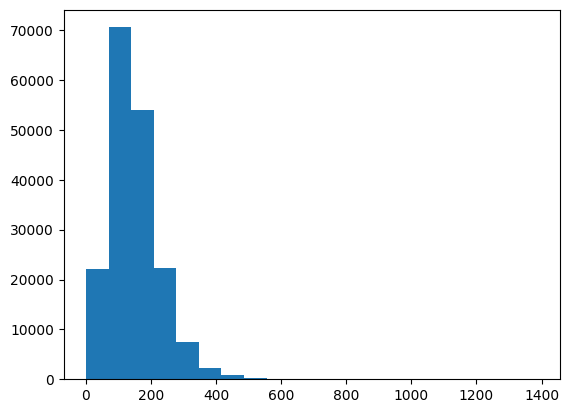

In [ ]:
# more looking through our data
plt.hist([len(sentence) for sentence in train_sentences] , bins = 20) ;

In [ ]:
# adapting character vectorizer to train characters
char_vectorizer.adapt(train_char)

In [ ]:
# getting character vocabulary from character vectorizer
char_vocab = char_vectorizer.get_vocabulary()
print(f"the total number of characters in vocabulary : {len(char_vocab)}")
print(f"the most used characters in vocabulary : {char_vocab[:5]}")
print(f"the laest used characters in vocabulary : {char_vocab[-5:]}")

the total number of characters in vocabulary : 28
the most used characters in vocabulary : ['', '[UNK]', 'e', 't', 'i']
the laest used characters in vocabulary : ['k', 'x', 'z', 'q', 'j']


In [ ]:
# making vectorization on a sample sentence
print(f"Text : \n {sample_sentence[0]} \n")
print(f"vectorized character set : \n {char_vectorizer(split_char(sample_sentence[0]))} \n")
print(f"the lenght of charcter set : {len(char_vectorizer(split_char(sample_sentence[0])))}")
print(f"the length of main sentence : {len(sample_sentence[0])}")

Text : 
 proportions of different dose of vaccine by age by vaccine were also identified . 

vectorized character set : 
 [14  8  7 14  7  8  3  4  7  6  9  7 17 10  4 17 17  2  8  2  6  3 10  7
  9  2  7 17 21  5 11 11  4  6  2 22 19  5 18  2 22 19 21  5 11 11  4  6
  2 20  2  8  2  5 12  9  7  4 10  2  6  3  4 17  4  2 10  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  

**setting-up character-level embedding layer**

In [ ]:
from tensorflow.keras.layers import Embedding

char_embedding = Embedding(input_dim = len(char_vocab) ,
                           output_dim = 25 ,
                           mask_zero = True ,
                           name = "char_embedded")

In [ ]:
# do an embedding on a sample sentence
print(f"Text splitted into chars: \n {split_char(sample_sentence[0])} \n")
print(f"the shape of character before embedding : \n {(char_vectorizer(split_char(sample_sentence[0]))).shape} \n")
print(f"the shape of character after embedding : \n {(char_embedding(char_vectorizer(split_char(sample_sentence[0])))).shape} \n")

Text splitted into chars: 
 p r o p o r t i o n s   o f   d i f f e r e n t   d o s e   o f   v a c c i n e   b y   a g e   b y   v a c c i n e   w e r e   a l s o   i d e n t i f i e d   . 

the shape of character before embedding : 
 (290,) 

the shape of character after embedding : 
 (290, 25) 



**Building model**

In [ ]:
# create model
inputs = tf.keras.Input(shape = (1,) , name = "input_layer" , dtype = tf.string)
x = char_embedding(char_vectorizer(inputs))
x = tf.keras.layers.Conv1D(64 , kernel_size = 5 , padding = "same" , activation = "relu")(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
outputs = tf.keras.layers.Dense(num_classes , name = "output_layer" , activation = "softmax")(x)
model_3 = tf.keras.Model(inputs , outputs)
# compile model
model_3.compile(loss = tf.keras.losses.categorical_crossentropy ,
                optimizer = tf.keras.optimizers.Adam() ,
                metrics = ["accuracy"])
# fit model
model_3_history = model_3.fit(train_dataset ,
                              steps_per_epoch = len(train_dataset) ,
                              epochs = 3 ,
                              validation_data = val_dataset ,
                              validation_steps = len(val_dataset))

Epoch 1/3
5627/5627 [==============================] - 33s 6ms/step - loss: 1.3175 - accuracy: 0.4362 - val_loss: 1.2984 - val_accuracy: 0.4470
Epoch 2/3
5627/5627 [==============================] - 30s 5ms/step - loss: 1.3038 - accuracy: 0.4419 - val_loss: 1.2962 - val_accuracy: 0.4470
Epoch 3/3
5627/5627 [==============================] - 31s 5ms/step - loss: 1.3018 - accuracy: 0.4420 - val_loss: 1.2946 - val_accuracy: 0.4471


In [ ]:
# making prediction (raw logits)
model_3_pred_prob = model_3.predict(val_dataset , verbose = 0)
# turning prediction probilities to prediction lables
model_3_pred_label = tf.argmax(model_3_pred_prob , axis = 1)
# calculating results
model_3_results = calculate_results(y_true = val_lables_encoded ,
                                    y_pred = model_3_pred_label) ;
model_3_results

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 44.71071097577122,
 'precision': 0.5071808905902501,
 'recall': 0.4471071097577122,
 'f1': 0.3632791695223773}

### 2.4 **Model 4 :**  Hybrid Embedding layer

Combining pretrained embedding layer + character embedding layer

In [ ]:
# token model
token_inputs = tf.keras.Input(shape = [] , dtype = tf.string , name = "token_input")
x = tf_hub_embedding_layer(token_inputs)
token_outputs = tf.keras.layers.Dense(128 , activation = "relu")(x)
token_model = tf.keras.Model(token_inputs , token_outputs)
# character embedding layer
char_input = tf.keras.Input(shape = (1,) , dtype = tf.string , name = "char_input")
x = char_embedding(char_vectorizer(char_input))
char_output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)
char_model = tf.keras.Model(char_input , char_output)

# concatenating char aand token model
char_token_concatenation = tf.keras.layers.Concatenate(name = "token_char_concatenation")([token_model.output ,char_model.output])

# creating last whole model layers
combined_dropout = tf.keras.layers.Dropout(0.5)(char_token_concatenation)
dense_dropout = tf.keras.layers.Dense(128 , activation = "relu")(combined_dropout)
final_dropout  = tf.keras.layers.Dropout(0.5)(dense_dropout)
output_layer = tf.keras.layers.Dense(num_classes , activation = "softmax" , name = "output_layer")(final_dropout)

# creating model
model_4 = tf.keras.Model(inputs = [token_model.input ,char_model.input] ,
                         outputs = output_layer ,
                         name = "model_4_hybrid_model")
# compile model
model_4.compile(loss = tf.keras.losses.categorical_crossentropy ,
                optimizer = tf.keras.optimizers.Adam() ,
                metrics = ["accuracy"])
# combining train char and token datasets
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences , train_char))
train_char_token_label = tf.data.Dataset.from_tensor_slices(train_one_hot_label)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data , train_char_token_label))
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# combining validation char and token dataset
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences , val_char))
val_char_token_label = tf.data.Dataset.from_tensor_slices(val_one_hot_label)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data , val_char_token_label))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# fit model
model_4_history = model_4.fit(train_char_token_dataset ,
                              steps_per_epoch = len(train_char_token_dataset) ,
                              epochs = 3 ,
                              validation_data = val_char_token_dataset ,
                              validation_steps = len(val_char_token_dataset))

Epoch 1/3
5627/5627 [==============================] - 374s 64ms/step - loss: 0.7596 - accuracy: 0.7103 - val_loss: 0.6282 - val_accuracy: 0.7612
Epoch 2/3
5627/5627 [==============================] - 391s 69ms/step - loss: 0.6719 - accuracy: 0.7460 - val_loss: 0.5983 - val_accuracy: 0.7731
Epoch 3/3
5627/5627 [==============================] - 283s 50ms/step - loss: 0.6443 - accuracy: 0.7579 - val_loss: 0.5774 - val_accuracy: 0.7817


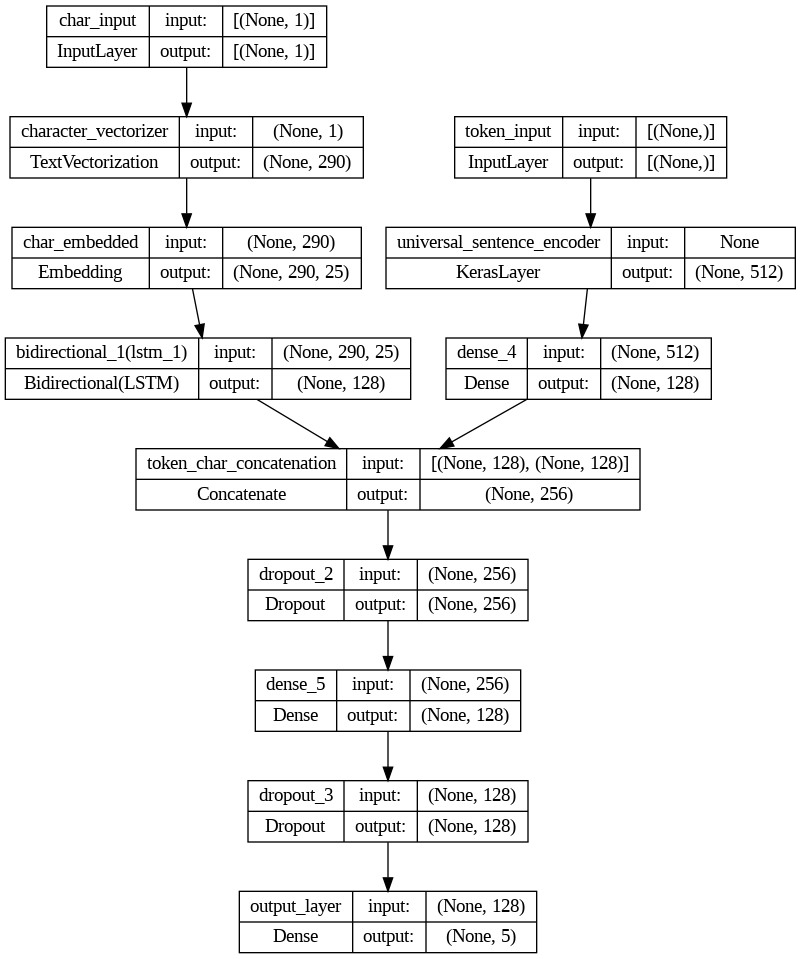

In [ ]:
# looking at model diagram
plot_model(model_4 , show_shapes = True)

In [ ]:
# making prediction (raw logits)
model_4_pred_prob = model_4.predict(val_char_token_dataset , verbose = 0)
# turning prediction probilities to prediction lables
model_4_pred_label = tf.argmax(model_4_pred_prob , axis = 1)
# calculating results
model_4_results = calculate_results(y_true = val_lables_encoded ,
                                    y_pred = model_4_pred_label)
model_4_results

{'accuracy': 78.17423540315107,
 'precision': 0.7802745647281181,
 'recall': 0.7817423540315107,
 'f1': 0.7781132974873336}

### 2.5 **Model 5 :** Transfer Learning

pretrained token embedding + character embedding + positional embedding

In [ ]:
train_df.head()

,line number,target,text,total lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,12
1,1,METHODS,a total of @ patients with primary knee oa wer...,12
2,2,METHODS,outcome measures included pain reduction and i...,12
3,3,METHODS,pain was assessed using the visual analog pain...,12
4,4,METHODS,secondary outcome measures included the wester...,12


❗ **Note**

Any engineering features used to train our model must be available for test data too . in this case we have line numbers and total lines .

**Positional embedding**

1. one-hot encoded tensors of `line number`
2. one-hot encoded tensors of `total lines`

In [ ]:
# finding the depth we must use for one hot encoding
np.percentile(train_df["line number"] , 95)

13.0

In [ ]:
# 1. line_number one-hot encoded
train_line_number_one_hot = tf.one_hot(train_df["line number"].to_numpy() , depth = 15)
val_line_number_one_hot = tf.one_hot(val_df["line number"].to_numpy() , depth = 15)
test_line_number_one_hot = tf.one_hot(test_df["line number"].to_numpy() , depth = 15)
train_line_number_one_hot[0]

<tf.Tensor: shape=(15,), dtype=float32, numpy=
array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>

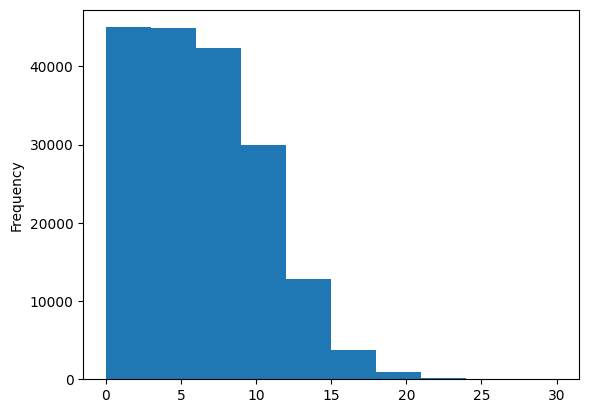

In [ ]:
train_df["line number"].plot.hist() ;

In [ ]:
train_df["line number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line number, dtype: int64

In [ ]:
# finding the depth we must use for one hot encoding
np.percentile(train_df["total lines"] , 95)

19.0

In [ ]:
# 2. total_lines one-hot encoded
train_total_lines_one_hot = tf.one_hot(train_df["total lines"].to_numpy() , depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df["total lines"].to_numpy() , depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df["total lines"].to_numpy() , depth = 20)


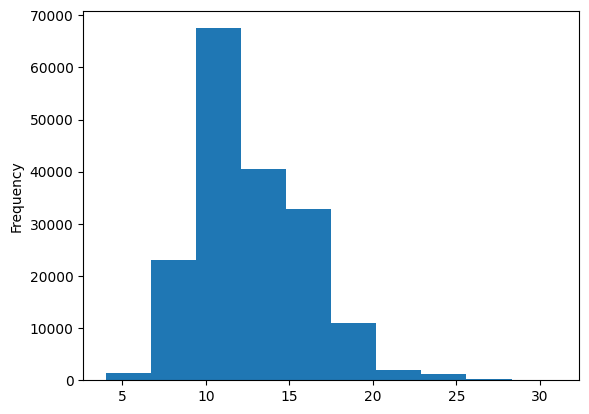

In [ ]:
train_df["total lines"].plot.hist() ;

In [ ]:
train_df["total lines"].value_counts()

12    24468
11    23639
13    22113
10    19400
14    18438
15    14610
9     12285
16    10768
8      7464
17     7429
18     5202
7      3353
19     3344
20     2480
21     1281
6      1146
22      770
23      759
24      264
5       215
25      200
26      182
27       81
29       58
4        32
31       31
28       28
Name: total lines, dtype: int64

**Building a tribrid model**

1. Create `token` model
2. Create `char` model
3. Create `line_number` model
4. Create `total_lines` model
5. combining the output of `token` , `char` and `combined_token_char` model after `dropout` using `tf.keras.layers.Concatenate`
6. combining the output of `line_number` & `total_lines` model using `tf.keras.layers.Concatenate`
7. Creating Dense layer as `output_layer` and
8. creating model using `tf.keras.Model`

In [ ]:
# 0. prerequirity : making our datasets compatible for model
# train dataset
train_token_char_pos_data = tf.data.Dataset.from_tensor_slices((train_sentences , train_char , train_line_number_one_hot , train_total_lines_one_hot))
train_token_char_pos_label = tf.data.Dataset.from_tensor_slices(train_one_hot_label)
train_token_char_pos_dataset = tf.data.Dataset.zip((train_token_char_pos_data , train_token_char_pos_label))
train_token_char_pos_dataset = train_token_char_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
# validation dataset
val_token_char_pos_data = tf.data.Dataset.from_tensor_slices((val_sentences , val_char , val_line_number_one_hot , val_total_lines_one_hot))
val_token_char_pos_label = tf.data.Dataset.from_tensor_slices(val_one_hot_label)
val_token_char_pos_dataset = tf.data.Dataset.zip((val_token_char_pos_data , val_token_char_pos_label))
val_token_char_pos_dataset = val_token_char_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_token_char_pos_dataset , val_token_char_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# 1. token model
token_inputs = tf.keras.Input(shape = [] , dtype = tf.string , name = "token_input") # note : input_shape = []
x = tf_hub_embedding_layer(token_inputs) # using pretrained embedding layer
token_outputs = tf.keras.layers.Dense(128 , activation = "relu")(x)
token_model = tf.keras.Model(token_inputs , token_outputs)

# 2. char model
char_inputs = tf.keras.Input(shape = (1,) , dtype = tf.string  , name = "char_input")
x = char_embedding(char_vectorizer(char_inputs))
char_outputs = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(x)
char_model = tf.keras.Model(char_inputs , char_outputs)

# 3. line_number model
line_number_inputs = tf.keras.Input(shape = (15,) , dtype = tf.float32 , name = "line_number_input")
line_number_outputs = tf.keras.layers.Dense(32 , activation = "relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs , line_number_outputs)

# 4. total_lines model
total_lines_inputs = tf.keras.Input(shape = (20,) , dtype = tf.float32 , name = "total_lines_input")
total_lines_outputs = tf.keras.layers.Dense(32 , activation = "relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs , total_lines_outputs)

# 5. combining output of token and char model
token_char_concatenate = tf.keras.layers.Concatenate(name = "token_char_concatenate")([token_model.output , char_model.output]) # combination
# Dense & dropout
dense_token_char_concatenate = tf.keras.layers.Dense(256 , activation = "relu")(token_char_concatenate) # Dense
dropout_dense_char_token_concatenate = tf.keras.layers.Dropout(0.5)(dense_token_char_concatenate) # Dropout

# 6. tribid embedding the combination of positional embedding ( line_number + total_lines ) + combined embedding ( token + char )
tribid_embedding = tf.keras.layers.Concatenate(name = "tribid_embedding")([line_number_model.output , total_lines_model.output , dropout_dense_char_token_concatenate])

# 7. Creating the output_layer
output_layer = tf.keras.layers.Dense(num_classes , activation = "softmax" , name = "output_layer")(tribid_embedding)

# 8. Creating the whole model
model_5 = tf.keras.Model(inputs = [token_model.input , char_model.input , line_number_model.input , total_lines_model.input] ,
                         outputs = output_layer ,
                         name = "tribid_embedding_model")
# compile model
model_5.compile(loss = tf.keras.losses.categorical_crossentropy ,
                optimizer = tf.keras.optimizers.Adam() ,
                metrics = ["accuracy"])
# fit model
model_5_history = model_5.fit(train_token_char_pos_dataset ,
                              steps_per_epoch = len(train_token_char_pos_dataset) ,
                              epochs = 3 ,
                              validation_data = val_token_char_pos_dataset ,
                              validation_steps = len(val_token_char_pos_dataset))

Epoch 1/3
5627/5627 [==============================] - 434s 75ms/step - loss: 0.4604 - accuracy: 0.8247 - val_loss: 0.3759 - val_accuracy: 0.8540
Epoch 2/3
5627/5627 [==============================] - 303s 54ms/step - loss: 0.3645 - accuracy: 0.8625 - val_loss: 0.3571 - val_accuracy: 0.8629
Epoch 3/3
5627/5627 [==============================] - 387s 69ms/step - loss: 0.3391 - accuracy: 0.8730 - val_loss: 0.3482 - val_accuracy: 0.8665


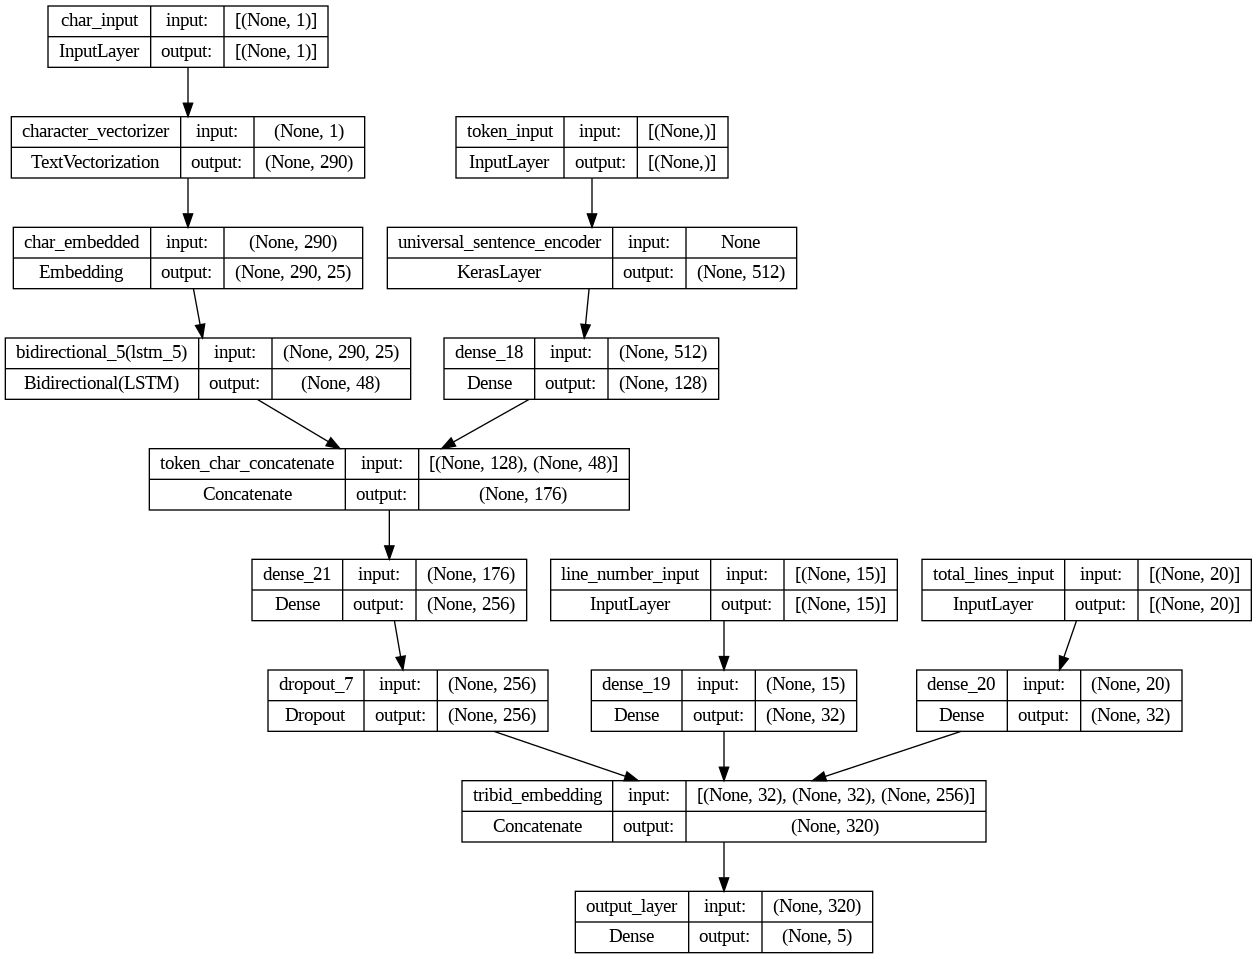

In [ ]:
# plot model diagram
plot_model(model_5 , show_shapes = True)

In [ ]:
# make prediction
model_5_pred_prob = model_5.predict(val_token_char_pos_dataset , verbose = 0)
# turning prediction probilities to prediction lables
model_5_pred_label = tf.argmax(model_5_pred_prob , axis = 1)
# calculating model results
model_5_results = calculate_results(y_true = val_lables_encoded,
                                    y_pred = model_5_pred_label)
model_5_results

{'accuracy': 86.64768965973785,
 'precision': 0.8681633509777108,
 'recall': 0.8664768965973785,
 'f1': 0.8639633898921392}

## 3. Compare model Results

In [ ]:
all_model_results = pd.DataFrame({"model_0_baseline" : model_0_results ,
                                  "model_1_custom_token_embedding" : model_1_results ,
                                  "model_2_pretrained_token_embedding" : model_2_results ,
                                  "model_3_custom_char_embedding" : model_3_results ,
                                  "model_4_hybrid_token_char_embedding" : model_4_results ,
                                  "model_5_tribid_token_char_pos_embedding" : model_5_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,80.703032,0.804345,0.807030,0.804539
model_2_pretrained_token_embedding,76.846948,0.765626,0.768469,0.764274
model_3_custom_char_embedding,44.710711,0.507181,0.447107,0.363279
model_4_hybrid_token_char_embedding,78.174235,0.780275,0.781742,0.778113
model_5_tribid_token_char_pos_embedding,86.647690,0.868163,0.866477,0.863963


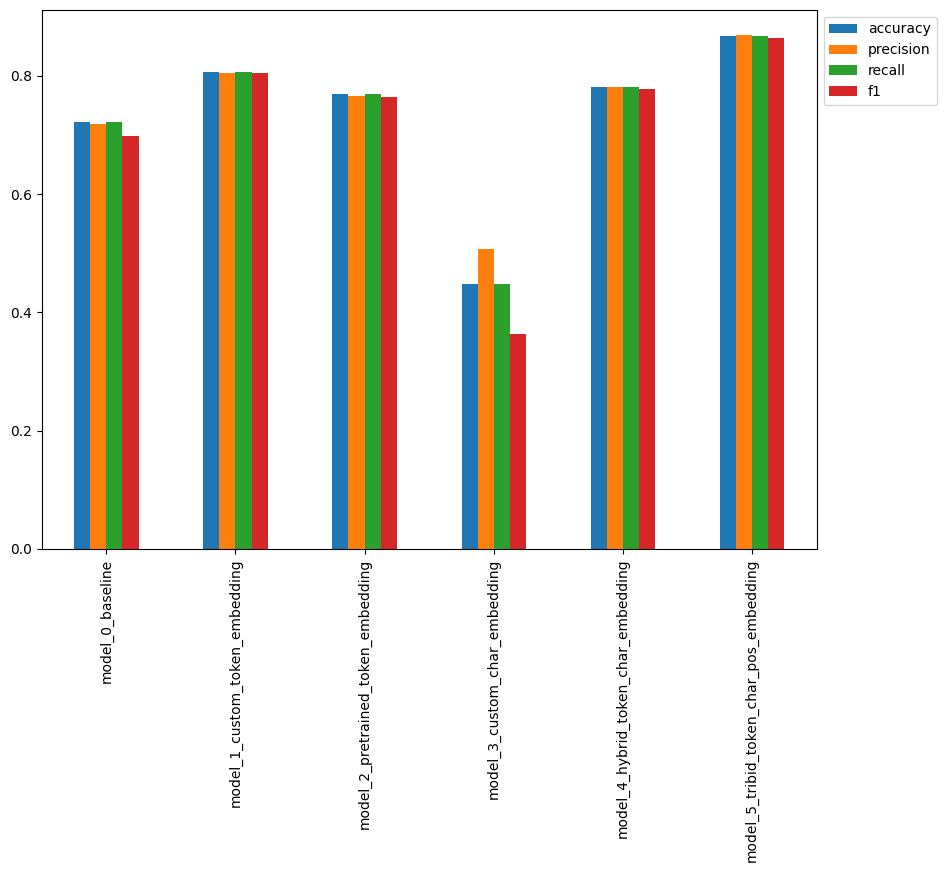

In [ ]:
# visualizing all model results
all_model_results["accuracy"] = all_model_results["accuracy"]/100  # we do this for making all of data in same scall
all_model_results.plot(kind = "bar" , figsize = (10,7)).legend(bbox_to_anchor = (1,1)) ;

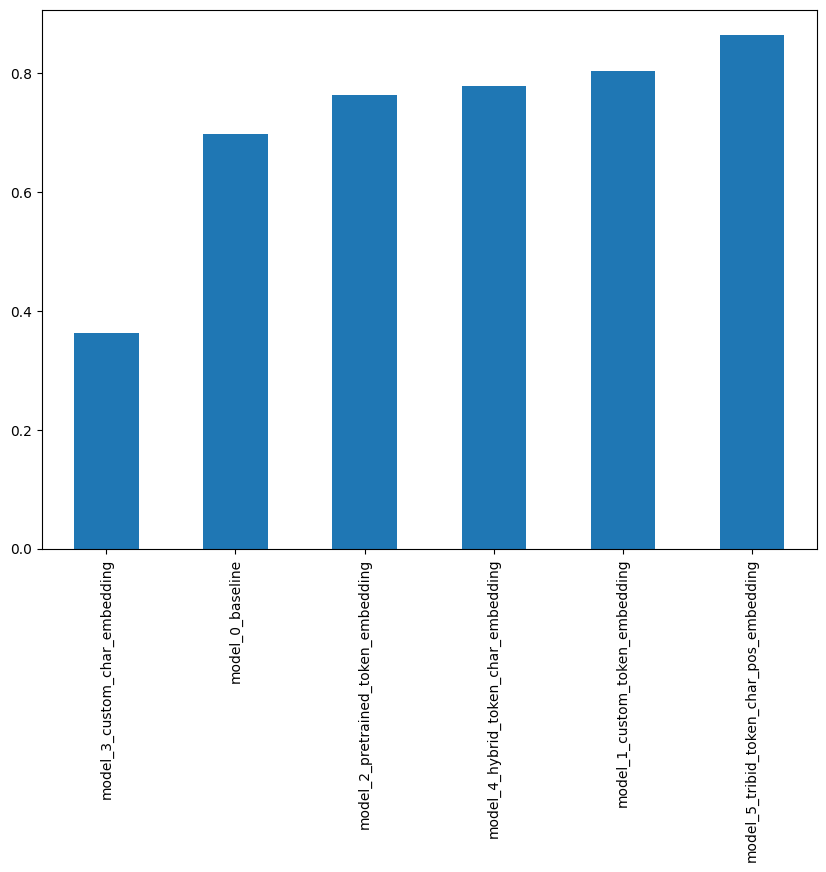

In [ ]:
# ploting values sorted
all_model_results.sort_values("f1" , ascending = True)["f1"].plot(kind = "bar" , figsize = (10,7)) ;

## 4. Save and load Model

In [ ]:
# save model
model_5.save("tribid_embedding_model")

In [ ]:
# load model
loaded_model = tf.keras.models.load_model("tribid_embedding_model")

In [ ]:
# calculating model results
loaded_model_pred = tf.argmax(loaded_model.predict(val_token_char_pos_dataset , verbose = 0) , axis = 1)
loaded_model_results = calculate_results(y_true = val_lables_encoded ,
                                         y_pred = loaded_model_pred)
loaded_model_results

{'accuracy': 86.64768965973785,
 'precision': 0.8681633509777108,
 'recall': 0.8664768965973785,
 'f1': 0.8639633898921392}

In [ ]:
for i in model_5_results :
  print(f"the equality for field : {i} is {np.isclose(model_5_results[i] , loaded_model_results[i])}")

the equality for field :accuracy is True
the equality for field :precision is True
the equality for field :recall is True
the equality for field :f1 is True
